# **Stanford Transportation - ChargePoint EV Chargers - Sep-2023**

## **Initialization**

### **Code Setup**

In [ ]:
import sys
from datetime import datetime, timedelta
from pathlib import Path
from typing import Optional

import matplotlib.dates
import networkx as nx
import pandas as pd
import seaborn as sns
import swifter
from IPython.display import display
from matplotlib import pyplot as plt
from zoneinfo import ZoneInfo

# sns.set_theme()

# Add repo's python directory to PYTHONPATH so we can import our utilities
sys.path.append("../python/")

from s3l_utils.dataset import Dataset
from s3l_utils.functional import grouper
from s3l_utils.notebook import print_md

%matplotlib widget

# Output formatting
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Timezone abbreviation to zoneinfo
tz_abbrev_to_zoneinfo = {
    "PDT": ZoneInfo("US/Pacific"),
    "PST": ZoneInfo("US/Pacific"),
}


# Convert alarm times to proper datetimes... why is this so hard???
def alarm_time_to_datetime(alarm_time):
    if isinstance(alarm_time, datetime):
        return alarm_time

    components = alarm_time.split()
    naive_time = datetime.strptime(" ".join(components[:-1]), "%Y-%m-%d %H:%M:%S")
    aware_time = naive_time.astimezone(tz_abbrev_to_zoneinfo[components[-1][1:-1]])
    return aware_time


# Summarize table
def summarize_dataframe_md(df: pd.DataFrame, header: str = ""):
    if header:
        print_md(f"#### **{header}**")

    print_md(f"**Number of Rows:** {len(df)}")
    print_md(f'**Columns:** {", ".join(df.columns)}')

    print_md("#### **Unique Column Values**")
    for column in df.columns:
        unique_column_values = ", ".join(filter(None, map(str, list(df[column].unique()))))
        print_md(f"##### **{column.strip()}**")
        print_md(unique_column_values)


# Pandas options
# pd.set_option('display.max_rows', None)


### **Load and Prepare Dataset**

In [ ]:
# Load dataset and tables
dataset = Dataset("../data/manifest.yml")
station_overview = dataset.stations.overview
alarms = dataset.reports.alarms
station_inventory = dataset.organizations.inventory.stations

# Canonicalize alarm times to US/Pacific datetimes
if not pd.api.types.is_datetime64_any_dtype(alarms["Alarm Time"]):
    # alarms['Alarm Time'] = pd.to_datetime(alarms['Alarm Time'].map(lambda x: ' '.join(x.split()[:-1]))).dt.tz_localize('US/Pacific', ambiguous='NaT')
    dst_map = alarms["Alarm Time"].str.contains("PST")
    alarms["Alarm Time"] = pd.to_datetime(alarms["Alarm Time"].map(lambda x: " ".join(x.split()[:-1]))).dt.tz_localize(
        "US/Pacific", dst_map
    )


## **Data Exploration**

### **Station Overview**

In [ ]:
summarize_dataframe_md(station_overview, "Station Overview Summary")


### **Station and Port Status**

In [ ]:
num_stations = len(station_overview)
num_ports = station_overview["No. of Ports"].sum()

print_md(f"**Number of Stations:** {num_stations}")
print_md(f"**Number of Ports:** {num_ports}")

print_md("#### **Station Count by Status**")
station_status_counts = station_overview.value_counts("Station Status")
assert num_stations == station_status_counts.sum()
display(station_status_counts.to_frame())

num_stations_need_service_or_watch_list = station_status_counts.loc[["Watch List", "Needs Service"]].sum()
percent_stations_need_service_or_watch_list = round(num_stations_need_service_or_watch_list / num_stations * 100, 2)
print_md(
    f"**Stations Needing Service or on Watch List:** {num_stations_need_service_or_watch_list} ({percent_stations_need_service_or_watch_list}%)"
)

print_md("#### **Port Count by Status**")
port_status_counts = station_overview[["Port 1 Status", "Port 2 Status"]].melt()["value"].value_counts().drop("")
assert num_ports == port_status_counts.sum()
display(port_status_counts.to_frame())

num_ports_need_service_or_watch_list = port_status_counts.loc[["Watch List", "Needs Service"]].sum()
percent_ports_need_service_or_watch_list = round(num_ports_need_service_or_watch_list / num_ports * 100, 2)
print_md(
    f"**Ports Needing Service or on Watch List:** {num_ports_need_service_or_watch_list} ({percent_ports_need_service_or_watch_list}%)"
)


### **Alarms**

In [ ]:
summarize_dataframe_md(alarms.drop("Alarm Time", axis=1), "Alarms Summary")


In [ ]:
alarm_name_vcs = alarms["Alarm Name"].value_counts()
display(alarm_name_vcs.sort_index())
for x in alarm_name_vcs.sort_index().index:
    print(x)
# alarm_name.hist(xrot=90, bins=alarm_name.nunique(), density=True)
ax = (alarm_name_vcs / alarm_name_vcs.sum()).plot.bar(color="black")
ax.grid()


## **Charger State Model**

### **Charger State Model**

In [ ]:
def calculate_state_from_alarms(alarms):
    from chargepoint import AlarmEnum, ChargerModel

    # Mapping from MAC addresses to models. Each MAC address corresponds to one unique charger model.
    models: dict[str, ChargerModel] = {}

    state_alarms = alarms.copy()
    state_alarms["State"] = pd.Series()

    # Iterate through all alarms chronologically and send to underlying charger state models.
    for index, row in state_alarms.sort_values("Alarm Time").iterrows():
        mac = row["MAC Address"]
        if mac in models:
            model = models[mac]
        else:
            model = ChargerModel(return_to_last_known_state=True)
            models[mac] = model

        alarm = AlarmEnum(row["Alarm Name"])
        model.send(alarm)
        state_alarms.loc[index, "State"] = model.state.station_status.current_state.name

    return state_alarms


state_alarms = calculate_state_from_alarms(alarms)


In [ ]:
state_alarms


### **State History**

In [ ]:
def build_state_history(state_alarms):
    # Sort state alarms by MAC Address and Alarm Time
    state_alarms = state_alarms.sort_values(["MAC Address", "Alarm Time"])

    # For duplicate alarm times (for a given charger), only keep latest alarm
    state_alarms = state_alarms.drop_duplicates(["MAC Address", "Alarm Time"], keep="last")

    state_history = None

    # Compute state history for each charger
    # Derived from:
    # https://www.codeforests.com/2021/03/30/group-consecutive-rows-in-pandas/
    # https://stackoverflow.com/questions/26911851/how-to-use-pandas-to-find-consecutive-same-data-in-time-series
    for mac, group in state_alarms.groupby("MAC Address"):
        group["Period"] = (group.State != group.State.shift()).cumsum()
        period_group = group.groupby("Period")
        charger_state_history = pd.DataFrame(
            {
                "State": period_group.State.first(),
                "Time": period_group["Alarm Time"].first(),
                "Alarms": period_group.size(),
            }
        ).reset_index(drop=True)

        charger_state_history["MAC Address"] = mac
        charger_state_history["Period"] = charger_state_history.index

        # Calculate duration
        charger_state_history["Duration"] = charger_state_history["Time"].shift(-1) - charger_state_history["Time"]

        # Order columns
        charger_state_history = charger_state_history[["MAC Address", "Period", "State", "Time", "Duration", "Alarms"]]

        # Concat
        if state_history is None:
            state_history = charger_state_history
        else:
            state_history = pd.concat([state_history, charger_state_history])

    return state_history


state_history = build_state_history(state_alarms).dropna()


In [ ]:
state_history


In [ ]:
state_history["Duration"].to_frame().describe()

## **Analysis**

### **Uptime Summary**

In [107]:
state_durations = state_history.pivot_table(
    index="MAC Address", columns="State", values="Duration", aggfunc="sum", fill_value=pd.Timedelta(seconds=0)
)
state_durations["Total"] = state_durations.sum(axis=1)

with pd.option_context("display.max_rows", None):
    display(state_durations)


State,Available,Faulted,Unavailable,Unknown,Unreachable,Total
MAC Address,,,,,,
000D:6F00:04F8:B0AC,113 days 06:52:47,124 days 05:54:46,0 days 00:00:00,0 days 00:00:00,71 days 23:31:54,309 days 12:19:27
0024:B100:0002:13E5,1853 days 10:17:50,11 days 00:05:33,0 days 06:44:49,0 days 00:00:00,118 days 02:23:36,1982 days 19:31:48
0024:B100:0002:15D0,1688 days 13:22:32,155 days 01:11:45,0 days 00:11:17,0 days 00:00:00,146 days 03:59:24,1989 days 18:44:58
0024:B100:0002:15D4,1745 days 21:53:27,95 days 05:24:42,0 days 00:35:38,0 days 00:00:00,146 days 16:11:35,1987 days 20:05:22
0024:B100:0002:15DF,1749 days 23:32:33,99 days 12:32:57,0 days 00:31:33,0 days 00:00:00,139 days 14:05:51,1989 days 02:42:54
0024:B100:0002:16F3,1969 days 23:55:54,8 days 12:00:09,7 days 19:02:35,0 days 00:00:00,6 days 23:27:26,1993 days 06:26:04
0024:B100:0002:1C6A,1753 days 10:40:09,85 days 08:26:49,0 days 00:31:19,0 days 00:00:00,149 days 00:27:05,1987 days 20:05:22
0024:B100:0002:1E24,1226 days 07:00:54,59 days 01:35:28,0 days 00:08:37,0 days 00:00:00,194 days 08:12:42,1479 days 16:57:41
0024:B100:0002:1EED,1724 days 21:21:21,73 days 02:30:09,0 days 02:59:39,0 days 00:00:00,197 days 23:24:22,1996 days 02:15:31


In [ ]:
state_percentages = state_durations.divide(state_durations["Total"], axis=0) * 100

with pd.option_context("display.max_rows", None):
    display(state_percentages)


In [106]:
state_percentages.describe()

State,Available,Faulted,Unavailable,Unknown,Unreachable,Total
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.0
mean,85.236026,8.056446,0.876718,0.000005,5.830804,100.0
std,16.976817,13.690712,3.017967,0.000060,6.767413,0.0
min,6.557406,0.000000,0.000000,0.000000,0.053668,100.0
25%,76.401054,0.404053,0.000000,0.000000,1.050387,100.0
50%,88.559900,3.242160,0.001343,0.000000,2.395177,100.0
75%,97.693265,9.849649,0.017102,0.000000,8.036935,100.0
max,99.838665,82.922008,19.368295,0.000670,37.925546,100.0


### **State History**

#### **Per-Charger Timeline**

In [ ]:
state_to_plot_map = {
    "Available": {
        # 'color': '#54CD48',
        "color": "#0080B2",
        "label": "Available",
    },
    "Faulted": {"color": "#D31144", "label": "Faulted"},
    "Unreachable": {"color": "#EEAC11", "label": "Unreachable"},
    "Unavailable": {"color": "#454545", "label": "Unavailable"},
    "Unknown": {"color": "black", "label": "Unknown"},
}

# %matplotlib qt
%matplotlib widget
fig, ax = plt.subplots()

for i, mac in enumerate(state_history["MAC Address"].unique()):
    # min_time = float('inf')
    y = i * 20
    for state, properties in state_to_plot_map.items():
        state_periods = state_history[(state_history["MAC Address"] == mac) & (state_history.State == state)]
        xranges = [(row.Time.timestamp(), row.Duration.total_seconds()) for _, row in state_periods.iterrows()]
        # if xranges:
        #     min_time = min(min([x[0] for x in xranges]), min_time)
        ax.broken_barh(xranges, (y, 10), **properties)
    # ax.text(min_time - 1, y, mac, ha='right', fontsize=8)
    # ax.annotate(mac, xy=(min_time, y), ha='right')

# locs = ax.get_xticks()
# labels = list(map(lambda x: pd.Timestamp(x, unit='s', tz='US/Pacific'), locs))
ax.xaxis.set_major_formatter(lambda x, pos: pd.Timestamp(x, unit="s", tz="US/Pacific"))
plt.xticks(rotation=90)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper center",
    bbox_to_anchor=(0.5, 1.1),
    fancybox=True,
    ncols=5,
    shadow=True,
)
plt.yticks([])
plt.ylabel("Charger")
plt.tight_layout()


#### **Resample State History**

In [ ]:
state_history["State"] = state_history["State"].astype("category")

resampled_state_history = state_history.pivot(columns="MAC Address", index="Time", values="State")

# ffill except last range of NaNs
resampled_state_history = resampled_state_history.apply(lambda series: series.loc[: series.last_valid_index()].ffill())

# Resample
resampled_state_history = resampled_state_history.resample("1T").ffill()

# ffill except last range of NaNs
# resampled_state_history = resampled_state_history.apply(lambda series: series.loc[:series.last_valid_index()].ffill())


In [ ]:
resampled_state_counts_csv_path = Path("./big_chungus.csv")
if resampled_state_counts_csv_path.exists():
    resampled_state_counts = pd.read_csv(resampled_state_counts_csv_path, index_col="Time")
    resampled_state_counts.index = pd.to_datetime(resampled_state_counts.index, utc=True).tz_convert("US/Pacific")
else:
    resampled_state_counts = resampled_state_history.swifter.apply(pd.Series.value_counts, axis=1)
    resampled_state_counts["Total"] = resampled_state_counts.sum(axis=1)
    resampled_state_counts = resampled_state_counts[resampled_state_counts["Total"] > 0]


In [ ]:
resampled_state_counts_normalized = resampled_state_counts.divide(resampled_state_counts["Total"], axis=0) * 100

In [ ]:
resampled_state_counts_normalized

#### **Summary Graphs**

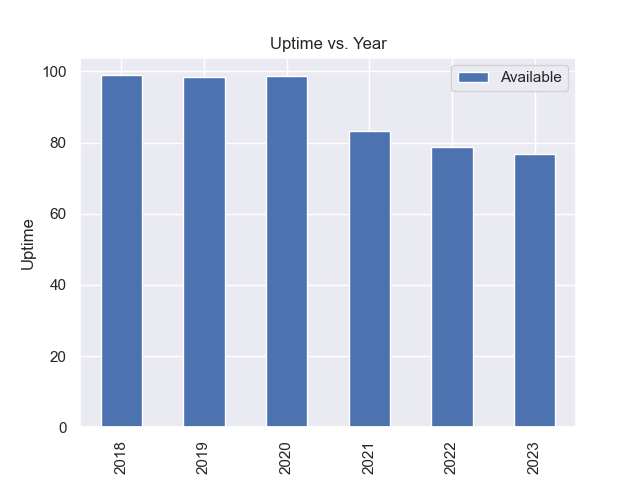

In [140]:
sns.set_theme()
ax = resampled_state_counts_normalized.groupby(resampled_state_counts_normalized.index.year).mean().plot.bar(y='Available', title='Uptime vs. Year', xlabel='Year', ylabel='Uptime')

#### **Summarized Timeline**

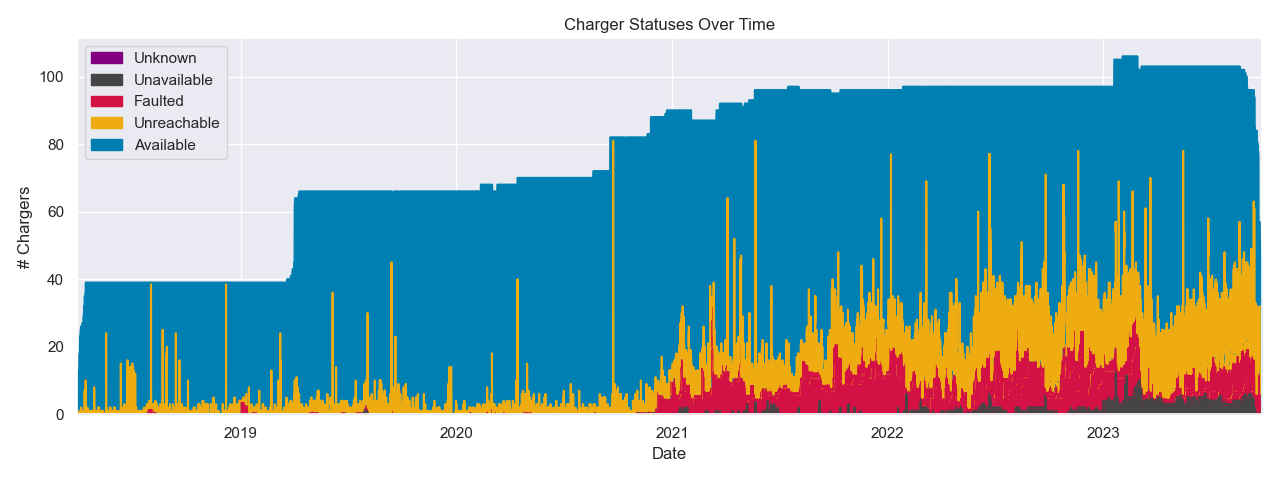

In [141]:
ax = resampled_state_counts.plot.area(
    y=["Unknown", "Unavailable", "Faulted", "Unreachable", "Available"],
    rot=0,
    ylabel="# Chargers",
    xlabel="Date",
    title="Charger Statuses Over Time",
    style={
        "Unknown": "purple",
        "Unavailable": "#454545",
        "Unreachable": "#EEAC11",
        "Faulted": "#D31144",
        "Available": "#0080B2",
    },
)

fig = ax.get_figure()
fig.set_figwidth(fig.get_figwidth() * 2)
ax.get_figure().tight_layout()

### **State Transition Frequency**

In [104]:
state_transitions_freq = (
    state_history[["MAC Address", "Period", "Duration"]]
    .groupby("MAC Address")
    .agg(Periods=pd.NamedAgg(column="Period", aggfunc="count"), Duration=pd.NamedAgg(column="Duration", aggfunc="sum"))
)
# state_transitions_freq['Duration / Period'] = state_transitions_freq['Duration'] / state_transitions_freq['Periods']
state_transitions_freq["Frequency"] = (state_transitions_freq["Periods"] - 0) / state_transitions_freq["Duration"].dt.seconds

with pd.option_context("display.max_rows", None):
    display(state_transitions_freq.sort_values("Frequency", ascending=False))


,Periods,Duration,Frequency
MAC Address,,,
0024:B100:0002:8DD9,5799,1632 days 00:05:59,16.153203
0024:B100:0002:8E32,5738,1632 days 00:31:49,3.005762
0024:B100:0002:9194,5739,1632 days 00:57:38,1.659630
0024:B100:0006:BC3D,321,566 days 00:06:45,0.792593
0024:B100:0003:33C3,1373,1470 days 00:39:21,0.581533
0024:B100:0002:9193,427,1632 days 00:18:10,0.391743
0024:B100:0002:594F,519,1453 days 00:22:55,0.377455
0024:B100:0002:9202,638,1632 days 00:33:07,0.321087
0024:B100:0002:91C3,451,1632 days 00:26:03,0.288548


#### **vs. Uptime**

<Axes: xlabel='Frequency', ylabel='Available'>

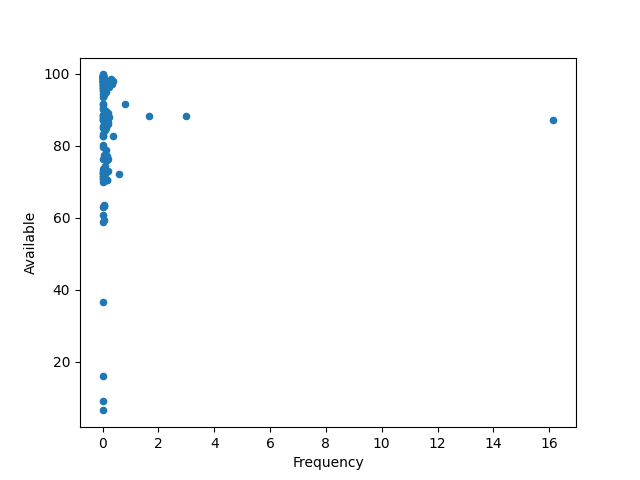

In [105]:
pd.concat([state_percentages, state_transitions_freq['Frequency']], axis=1).sort_values('Frequency', ascending=False).plot.scatter(x='Frequency', y='Available')


### **By Location**

##### **Build Station MAC to Location Tables**

In [142]:
# Inventory - MAC, Name, Location
inventory_mac_name_address = station_inventory[["MAC Address", "Station Name", "Address"]]
inventory_mac_name_address = inventory_mac_name_address.rename(columns={"Address": "Location", "Station Name": "Name"})
inventory_mac_name_address = inventory_mac_name_address.sort_values("MAC Address", ignore_index=True)

# Alarms - MAC, Name, Location
alarms_mac_name_location = alarms[["MAC Address", "Display Name"]].drop_duplicates()

# Map some locations using alarm MAC addresses
alarms_mac_name_location["Location"] = alarms_mac_name_location.merge(
    station_inventory[["MAC Address", "Address"]], left_on="MAC Address", right_on="MAC Address"
)["Address"]

# Map some locations using display / station names
alarms_missing_location = alarms_mac_name_location[alarms_mac_name_location["Location"].isna()]
alarms_mac_name_location.update(
    alarms_missing_location.drop("Location", axis=1)
    .merge(station_inventory[["Station Name", "Address"]], how="left", left_on="Display Name", right_on="Station Name")
    .set_index(alarms_missing_location.index)
    .rename(columns={"Address": "Location"})
)

alarms_mac_name = alarms_mac_name_location.rename(columns={"Address": "Location", "Display Name": "Name"}).sort_values(
    "MAC Address", ignore_index=True
)

# Combined Alarms and Inventory table
station_mac_name_location = (
    pd.concat([inventory_mac_name_address, alarms_mac_name], ignore_index=True)
    .drop_duplicates()
    .sort_values("MAC Address", ignore_index=True)
)

# Map some locations using duplicate MACs
## First get all duplicates
duplicate_stations_mac = station_mac_name_location[
    station_mac_name_location.duplicated(subset="MAC Address", keep=False)
]

## Drop duplicates from frame. We will add back the resolved duplicates later.
print(len(station_mac_name_location))
station_mac_name_location.drop(duplicate_stations_mac.index, inplace=True)
print(len(station_mac_name_location))

def duplicate_resolver(duplicates):
    rows = []
    for mac, group in duplicates.groupby("MAC Address"):
        # If a row already has a location, use that
        if len(group[group["Location"].notna()]):
            rows.append(group[group["Location"].notna()][:1])

    resolved_duplicates = pd.concat(rows)
    return resolved_duplicates


## Resolve duplicates and add back to combined frame
resolved_duplicates = duplicate_resolver(duplicate_stations_mac)
station_mac_name_location = pd.concat([station_mac_name_location, resolved_duplicates]).sort_values("Name", ignore_index=True)

# Remaining
alarms_missing_location = station_mac_name_location[station_mac_name_location["Location"].isna()]

with pd.option_context("display.max_rows", None):
    print_md("**Inventory: MAC, Name, Location**")
    display(inventory_mac_name_address)

    print_md("**Alarms: MAC, Name, Location**")
    display(alarms_mac_name)

    print_md("**Duplicate Stations (by MAC)**")
    display(duplicate_stations_mac)

    print_md("**Resolved Duplicates**")
    display(resolved_duplicates)

    print_md("**Resolved Stations: MAC, Name, Location**")
    display(station_mac_name_location)

    print_md("**Remaining MACs with no Location**")
    display(alarms_missing_location)


207
53


**Inventory: MAC, Name, Location**

,MAC Address,Name,Location
0,000D:6F00:04F8:B0AC,SRWC / CHARGER 5,"585 Broadway, Redwood City, California 94063, ..."
1,0024:B100:0002:13E5,STANFORD / STATION 4 PS-5,"340 Oak Rd, Stanford, California 94305, United..."
2,0024:B100:0002:15D0,STANFORD / STATION 6 PS-5,"340 Oak Rd, Stanford, California 94305, United..."
3,0024:B100:0002:15D4,STANFORD / STATION 8 PS-5,"340 Oak Rd, Stanford, California 94305, United..."
4,0024:B100:0002:15DF,STANFORD / STATION 5 PS-5,"340 Oak Rd, Stanford, California 94305, United..."
5,0024:B100:0002:16F3,STANFORD / TH WALL MOUNT,"295 Galvez St, Stanford, California 94305, Uni..."
6,0024:B100:0002:1C6A,STANFORD / STATION 7 PS-5,"340 Oak Rd, Stanford, California 94305, United..."
7,0024:B100:0002:1EED,STANFORD / STATION 1 PS-5,"360 Oak Rd, Stanford, California 94305, United..."
8,0024:B100:0002:1F6C,STANFORD / STATION 3 PS-5,"360 Oak Rd, Stanford, California 94305, United..."
9,0024:B100:0002:2940,ROBLE / ROBLE LL1-7,"287 Santa Teresa St, Stanford, California 9430..."


**Alarms: MAC, Name, Location**

,MAC Address,Name,Location
0,000D:6F00:04F8:B0AC,STANFORD / CHARGER 5,NaN
1,0024:B100:0002:13E5,STANFORD / STATION 4 PS-5,"340 Oak Rd, Stanford, California 94305, United..."
2,0024:B100:0002:15D0,STANFORD / STATION 6 PS-5,"340 Oak Rd, Stanford, California 94305, United..."
3,0024:B100:0002:15D4,STANFORD / STATION 8 PS-5,"340 Oak Rd, Stanford, California 94305, United..."
4,0024:B100:0002:15DF,STANFORD / STATION 5 PS-5,"340 Oak Rd, Stanford, California 94305, United..."
5,0024:B100:0002:16F3,STANFORD / TH WALL MOUNT,"742 Campus Drive, Stanford, California 94305, ..."
6,0024:B100:0002:1C6A,STANFORD / STATION 7 PS-5,"340 Oak Rd, Stanford, California 94305, United..."
7,0024:B100:0002:1E24,STANFORD / STATION 2 PS-5,"360 Oak Rd, Stanford, California 94305, United..."
8,0024:B100:0002:1EED,STANFORD / STATION 1 PS-5,"360 Oak Rd, Stanford, California 94305, United..."
9,0024:B100:0002:1F61,STANFORD / STATION 2 TMU,"526-566 Lagunita Dr, Stanford, California 9430..."


**Duplicate Stations (by MAC)**

,MAC Address,Name,Location
0,000D:6F00:04F8:B0AC,SRWC / CHARGER 5,"585 Broadway, Redwood City, California 94063, ..."
1,000D:6F00:04F8:B0AC,STANFORD / CHARGER 5,NaN
6,0024:B100:0002:16F3,STANFORD / TH WALL MOUNT,"295 Galvez St, Stanford, California 94305, Uni..."
7,0024:B100:0002:16F3,STANFORD / TH WALL MOUNT,"742 Campus Drive, Stanford, California 94305, ..."
12,0024:B100:0002:1F6C,STANFORD / STATION 3 PS-5,"425 Broadway, Redwood City, California 94063, ..."
13,0024:B100:0002:1F6C,STANFORD / STATION 3 PS-5,"360 Oak Rd, Stanford, California 94305, United..."
16,0024:B100:0002:2940,ROBLE / ROBLE LL1-7,"2850 Bay Rd, Redwood City, California 94063, U..."
17,0024:B100:0002:2940,ROBLE / ROBLE LL1-7,"287 Santa Teresa St, Stanford, California 9430..."
18,0024:B100:0002:294E,ROBLE / ROBLE LL2-13,"425 Broadway, Redwood City, California 94063, ..."
19,0024:B100:0002:294E,ROBLE / ROBLE LL2-13,"373 Santa Teresa St, Stanford, California 9430..."


**Resolved Duplicates**

,MAC Address,Name,Location
0,000D:6F00:04F8:B0AC,SRWC / CHARGER 5,"585 Broadway, Redwood City, California 94063, ..."
6,0024:B100:0002:16F3,STANFORD / TH WALL MOUNT,"295 Galvez St, Stanford, California 94305, Uni..."
12,0024:B100:0002:1F6C,STANFORD / STATION 3 PS-5,"425 Broadway, Redwood City, California 94063, ..."
16,0024:B100:0002:2940,ROBLE / ROBLE LL1-7,"2850 Bay Rd, Redwood City, California 94063, U..."
18,0024:B100:0002:294E,ROBLE / ROBLE LL2-13,"425 Broadway, Redwood City, California 94063, ..."
20,0024:B100:0002:2954,ROBLE / ROBLE LL1-6,"425 Broadway, Redwood City, California 94063, ..."
22,0024:B100:0002:2955,ROBLE / ROBLE LL2-3,"742 Campus Drive, Stanford, California 94305, ..."
24,0024:B100:0002:295F,ROBLE / ROBLE LL2-9,"287 Santa Teresa St, Stanford, California 9430..."
27,0024:B100:0002:297C,ROBLE / ROBLE LL2-2,"425 Broadway, Redwood City, California 94063, ..."
29,0024:B100:0002:299E,ROBLE / ROBLE LL1-DIS,"425 Broadway, Redwood City, California 94063, ..."


**Resolved Stations: MAC, Name, Location**

,MAC Address,Name,Location
0,0024:B100:0002:5158,ROBLE / ROBLE LL1-1,"453 Quarry Rd, Palo Alto, California 94304, Un..."
1,0024:B100:0004:5CE8,ROBLE / ROBLE LL1-10,"373 Santa Teresa St, Stanford, California 9430..."
2,0024:B100:0002:2A89,ROBLE / ROBLE LL1-10,"373 Santa Teresa St, Stanford, California 9430..."
3,0024:B100:0002:3F5A,ROBLE / ROBLE LL1-11,"287 Santa Teresa St, Stanford, California 9430..."
4,0024:B100:0002:5150,ROBLE / ROBLE LL1-12,"287 Santa Teresa St, Stanford, California 9430..."
5,0024:B100:0004:0EC1,ROBLE / ROBLE LL1-12,"373 Santa Teresa St, Stanford, California 9430..."
6,0024:B100:0002:29C6,ROBLE / ROBLE LL1-2,"373 Santa Teresa St, Stanford, California 9430..."
7,0024:B100:0004:20C4,ROBLE / ROBLE LL1-2,"373 Santa Teresa St, Stanford, California 9430..."
8,0024:B100:0002:2A73,ROBLE / ROBLE LL1-3,"373 Santa Teresa St, Stanford, California 9430..."
9,0024:B100:0002:2963,ROBLE / ROBLE LL1-4,"373 Santa Teresa St, Stanford, California 9430..."


**Remaining MACs with no Location**

,MAC Address,Name,Location
85,0024:B100:0002:8F36,STANFORD / RWC B1 3,NaN
86,0024:B100:0002:91B6,STANFORD / RWC L1 1,NaN
